# Import libs and setup

In [1]:
import requests as re
from bs4 import BeautifulSoup
import sqlite3
from datetime import date
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm.notebook import tqdm

class CFG:
    PATH_TO_DB = './data/board_games.sqlite'
    PATH_FOR_TMP_BG_FILES = './data/scraped/bgg_boardgame_tmp'
    PATH_FOR_TMP_USER_FILES = './data/scraped/bgg_user_tmp'
    PATH_TO_SAVE_USER_FILES = './data/scraped/bgg_user'
    PATH_TO_TMP_FILES = './data/scraped/tmp'

# Get data from database
На основании опыта использования сервиса по большей части оценка больше 7 однозначно говорит о том, что игра вызвала положительные впечатления. Поэтому будет обучать модель на оценках больше или равными 7 баллов.

In [2]:
%%time
conn = sqlite3.connect(CFG.PATH_TO_DB)
query = '''
        SELECT *
        FROM ratings
        WHERE rating > 7
        ORDER BY user_id, last_modified
        '''
df = pd.read_sql(query, conn)
conn.close()
df

CPU times: user 1min 3s, sys: 13 s, total: 1min 16s
Wall time: 1min 31s


,rating_id,user_id,boardgame_id,rating,num_of_plays,comment_id,own,prevowned,for_trade,want,want_to_play,want_to_buy,wishlist,preordered,last_modified
0,1381940,5,463,9.0,50,450265.0,1,0,0,0,0,0,0,0,2004-12-10
1,1381858,5,35677,8.0,12,450185.0,1,0,0,0,0,0,0,0,2008-10-29
2,1382117,5,35761,8.0,1,NaN,0,0,0,0,0,0,0,0,2008-10-29
3,1381596,5,1823,8.0,20,449932.0,1,0,0,0,0,0,0,0,2009-05-18
4,1381597,5,421,8.0,24,449933.0,1,0,0,0,0,0,0,0,2009-05-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9218418,1008384,1669689,204472,7.5,0,337613.0,1,0,0,0,0,0,0,0,2022-11-04
9218419,1008294,1669689,251661,8.0,0,337530.0,1,0,0,0,0,0,0,0,2022-11-14
9218420,1008345,1669689,169426,8.0,0,337576.0,1,0,0,0,0,0,0,0,2022-11-14
9218421,1008119,1669689,18602,7.5,0,337365.0,0,0,0,0,0,0,0,0,2022-12-05


In [2]:
%%time
conn = sqlite3.connect(CFG.PATH_TO_DB)
query = '''
        SELECT user_id, boardgame_id, rating
        FROM ratings
        WHERE rating > 7
        ORDER BY user_id, last_modified
        '''
df = pd.read_sql(query, conn)
conn.close()

CPU times: user 18.9 s, sys: 2.22 s, total: 21.1 s
Wall time: 22.1 s


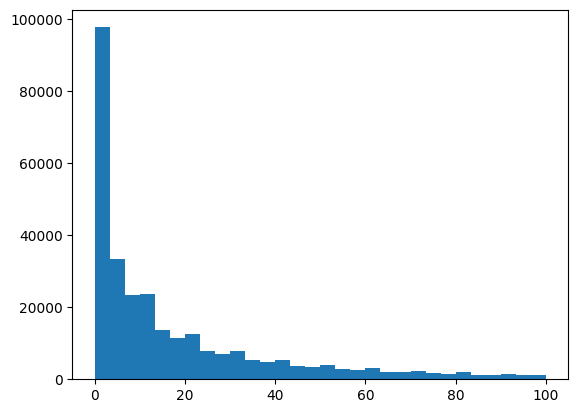

In [3]:
n_games = df.groupby('user_id').count()['boardgame_id']
plt.hist(n_games, bins=30, range=(0, 100))
plt.show()

Изначально предполагали взять 90й персентиль для определения последовательности для обучения, но так как распределение логнормальное, поэтому в данному случае из-за большого количества юзеров много пользователей с одной оценкой. Поэтому выберем экспертно подходящую нам длину последовательности положительных оценок.

In [4]:
n_games.quantile(0.5)

10.0

In [5]:
df.head()

,user_id,boardgame_id,rating
0,5,463,9.0
1,5,35677,8.0
2,5,35761,8.0
3,5,1823,8.0
4,5,421,8.0


In [8]:
len(n_games[n_games >= 10].index), len(n_games[n_games >= 11].index)

(158124, 151558)

# Prepare data
Подготовим данные, заменив рейтинги на отклонение от средней оценки каждого пользователя

In [6]:
df[df.user_id.isin(list(n_games[n_games >= 11].index))]

,user_id,boardgame_id,rating
0,5,463,9.0
1,5,35677,8.0
2,5,35761,8.0
3,5,1823,8.0
4,5,421,8.0
...,...,...,...
9218417,1669689,245934,8.0
9218418,1669689,204472,7.5
9218419,1669689,251661,8.0
9218420,1669689,169426,8.0


In [23]:
filtered_df = df[df.user_id.isin(list(n_games[n_games >= 11].index))]

In [27]:
filtered_df.groupby('user_id')['rating'].transform(lambda x: x - x.mean())

0          0.994845
1         -0.005155
2         -0.005155
3         -0.005155
4         -0.005155
             ...   
9218417   -0.097967
9218418   -0.597967
9218419   -0.097967
9218420   -0.097967
9218421   -0.597967
Name: rating, Length: 8649164, dtype: float64

In [29]:
filtered_df.rating = filtered_df.groupby('user_id')['rating'].transform(lambda x: x - x.mean())

/var/folders/g8/brdkwrws1mj2h2g5gb9xv8p00000gn/T/ipykernel_19742/220792868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rating = filtered_df.groupby('user_id')['rating'].transform(lambda x: x - x.mean())


In [30]:
filtered_df

,user_id,boardgame_id,rating
0,5,463,0.994845
1,5,35677,-0.005155
2,5,35761,-0.005155
3,5,1823,-0.005155
4,5,421,-0.005155
...,...,...,...
9218417,1669689,245934,-0.097967
9218418,1669689,204472,-0.597967
9218419,1669689,251661,-0.097967
9218420,1669689,169426,-0.097967


In [59]:
df

,user_id,boardgame_id,rating
0,5,463,9.0
1,5,35677,8.0
2,5,35761,8.0
3,5,1823,8.0
4,5,421,8.0
...,...,...,...
9218418,1669689,204472,7.5
9218419,1669689,251661,8.0
9218420,1669689,169426,8.0
9218421,1669689,18602,7.5


In [61]:
df.rating = df.groupby('user_id')['rating'].transform(lambda x: x - x.mean())

In [62]:
df

,user_id,boardgame_id,rating
0,5,463,0.994845
1,5,35677,-0.005155
2,5,35761,-0.005155
3,5,1823,-0.005155
4,5,421,-0.005155
...,...,...,...
9218418,1669689,204472,-0.597967
9218419,1669689,251661,-0.097967
9218420,1669689,169426,-0.097967
9218421,1669689,18602,-0.597967


# Generate dataset

In [71]:
%%time
scores_seq = []
games_seq = []
len_seq = 10+1
for user_id in list(n_games[n_games >= len_seq].index):
    games = list(df[df.user_id == user_id].boardgame_id)
    scores = list(df[df.user_id == user_id].rating)
    if len(seq) > 11:
        for i in range(len(games)-len_seq+1):
            games_seq.append(games[i:i+len_seq])
            scores_seq.append(scores[i:i+len_seq])

CPU times: user 42min 42s, sys: 2min 31s, total: 45min 13s
Wall time: 45min 39s


In [72]:
np.array(games_seq).shape, np.array(scores_seq).shape

((7133584, 11), (7133584, 11))

# Save dataset

In [73]:
file = open("./data/games_seq.np", "wb") # save array to the file np.save(file, arr) # close the file file.close
np.save(file, np.array(games_seq))
file.close

file = open("./data/scores_seq.np", "wb") # save array to the file np.save(file, arr) # close the file file.close
np.save(file, np.array(scores_seq))
file.close

<function BufferedWriter.close>